In [14]:
# Official packages
import os
import copy
import math

# Third-party packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# In-house packages
from BrukerSpSpEpi import BrukerSpSpEpiExp


In [15]:


def zerofill_fid_2d(fid_2d):
    nbr_zerofill_lines = spsp_epi._exp_data_dim_dict['dim_r_image_ph'] - spsp_epi._exp_data_dim_dict['dim_k_raw_ph']
    zerofilled_fid_2d = np.pad(fid_2d, ((nbr_zerofill_lines, 0),(0, 0)), 'constant', constant_values=(0))
    return zerofilled_fid_2d

def split_fid_2d(fid_2d):
    fid_left = fid_2d[...,:spsp_epi._exp_data_dim_dict['dim_k_raw_ro']:]
    fid_right = fid_2d[...,spsp_epi._exp_data_dim_dict['dim_k_raw_ro']::]
    return fid_left, fid_right

def mirror_odd_lines(fid_2d):
    mirrored_fid_2d = copy.deepcopy(fid_2d)
    for line_nbr, line in enumerate(mirrored_fid_2d):
        if (line_nbr % 2 ):
             mirrored_fid_2d[line_nbr] = line[::-1,...]
    return mirrored_fid_2d

def synthesize_phase_conjugate_fid_2d(fid_2d):
    synthesized_fid_2d = copy.deepcopy(fid_2d)
    for line_idx, line in enumerate(fid_2d):
        if (not line.any()):
            line = zerofilled_fid_2d[-1*line_idx]
            synthesized_fid_2d[line_idx] = line[::-1]
    return synthesized_fid_2d

def align_echo_center(fid_2d):
    aligned_fid_2d = copy.deepcopy(fid_2d)
    for idx, line in enumerate(fid_2d):
        shift = 60 - np.argmax(np.abs(line))
        aligned_fid_2d[idx] = np.roll(line, shift)
    return aligned_fid_2d

def _normalize(array):
    return array/np.max(array)

def view_epi_slice_3d(spsp_epi_exp):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    #X, Y, Z = axes3d.get_test_data(0.01)

    _x = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ro'], 1 )
    _y = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ph'], 1)

    X, Y = np.meshgrid(_x, _y)
    Z = _normalize(spsp_epi_exp.r_space_data['Mag'])

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, cmap=cm.RdGy_r, linewidth=0.5, antialiased=False,alpha=0.25)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph
    cset = ax.contour(X, Y, Z, zdir='z', offset=-.1, cmap=cm.seismic, alpha=0.99)

    x = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ro'], 1 )
    y = _normalize(spsp_epi_exp.magnitude_proj['ph'])
    ax.plot(x, y, zs=0, zdir='x', label='curve in (x, y)')

    x = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ph'], 1 )
    y = _normalize(spsp_epi_exp.magnitude_proj['ro'])
    ax.plot(x, y, zs=120, zdir='y', label='curve in (x, y)')

    ax.set_xlim(-0, 120)
    ax.set_ylim(-0, 120)
    ax.set_zlim(-.1, 1)

    ax.set_xlabel('Ph-Direction')
    ax.set_ylabel('RO-Direction')
    ax.set_zlabel('Normalized Intensity [1]')

    plt.show()



def process_fid(raw_fid):
    test_fid = np.array(np.array_split(raw_fid,16))
    k_space = {}
 
    k_space['Pos'] = np.squeeze(test_fid[...,:16:])
    k_space['Neg'] = np.squeeze(test_fid[...,16::])
    
    r_space["Pos"] = np.fft.fftshift(np.fft.fft2(k_space["Pos"]))
    r_space["Neg"] = np.fft.fftshift(np.fft.fft2(k_space["Neg"]))
    r_space["Abs"]  = np.abs(r_space['Pos']) + np.abs(r_space['Neg'])

    return k_space, r_space

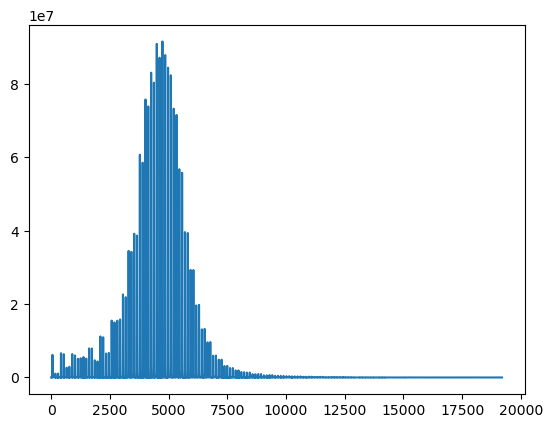

In [16]:
calib_exp_dir = "../20230305_163320_AgroseCylinder2_1_1/21"
        
spsp_epi_calib = BrukerSpSpEpiExp(calib_exp_dir, metabolite_list = ['Urea'])

plt.plot(np.abs(spsp_epi_calib.data))

overflow_exp_dir = "../LTL610_014_HP_spspEPI_6.0.1//20"

spsp_epi_overflow = BrukerSpSpEpiExp(overflow_exp_dir)

In [109]:
intervals = np.tile(spsp_epi_overflow.param_dict['ACQ_repetition_time']/1000, reps=spsp_epi_overflow.param_dict['NR']) + np.tile(spsp_epi_overflow.param_dict['Vd1List'], reps=int(spsp_epi_overflow.param_dict['NR'] / spsp_epi_overflow.param_dict["NumChemicalShifts"]))

intervals = np.concatenate((np.array([0]), intervals[:-1:]))

intervals = np.cumsum(intervals)

print(intervals)

[ 0.        0.100001  0.200002  3.300003  3.400004  3.500005  6.600006
  6.700007  6.800008  9.900009 10.00001  10.100011 13.200012 13.300013
 13.400014 16.500015 16.600016 16.700017 19.800018 19.900019 20.00002
 23.100021 23.200022 23.300023 26.400024 26.500025 26.600026 29.700027
 29.800028 29.900029 33.00003  33.100031 33.200032 36.300033 36.400034
 36.500035 39.600036 39.700037 39.800038 42.900039 43.00004  43.100041
 46.200042 46.300043 46.400044 49.500045 49.600046 49.700047 52.800048
 52.900049 53.00005  56.100051 56.200052 56.300053]


In [110]:
transient_idx = range(int(spsp_epi_overflow.param_dict['NR'] / spsp_epi_overflow.param_dict["NumChemicalShifts"]))
DEFAULT_METABOLITES = ['Urea','Pyruvate','Lactate']
indices= pd.MultiIndex.from_product([transient_idx,DEFAULT_METABOLITES],
                           names=[ 'idx', 'metabolite'])

TRANSIENT_ENTRIES = {
    "time_pts"      : "float",
    "raw_fid"       : "object",
    "k_space_pos"   : "object",
    "k_space_neg"   : "object",
    "r_image_pos"   : "object",
    "r_image_neg"   : "object",
    "r_image_abs"   : "object"
}

def generate_transient_space() -> dict[str, pd.DataFrame]:
    transient_space = {}
    for metabolite in DEFAULT_METABOLITES:
        transient_space[metabolite] = pd.DataFrame( 
                                            
                                            index = indices
                                        )
    return transient_space

In [128]:
df0 = generate_transient_space()

df1 = pd.DataFrame( data=intervals, columns=['time_pts'], index=indices)

iiter = [np.eye(2)*val for val in intervals]

df2 = pd.DataFrame( data=iiter, columns='a', index=indices)


ValueError: Must pass 2-d input. shape=(54, 2, 2)

In [124]:
new_var = df1, df2
pd.concat([new_var], axis=0, join="outer")

time_pts  k_space_pos
idx metabolite                       
0   Urea        0.000000          NaN
    Pyruvate    0.100001          NaN
    Lactate     0.200002          NaN
1   Urea        3.300003          NaN
    Pyruvate    3.400004          NaN
...                  ...          ...
16  Pyruvate         NaN    52.900049
    Lactate          NaN    53.000050
17  Urea             NaN    56.100051
    Pyruvate         NaN    56.200052
    Lactate          NaN    56.300053

[108 rows x 2 columns]